Empirical Application: Data Analysis. This Jupyter notebook contains the necessary Python code to reproduce the empirical results in the paper "Functional Partial Least-Squares: Adaptive Estimation and Inference" by Andrii Babii, Marine Carrasco, and Idriss Tsafack. 

The code was tested on Python v3.12.7.

In [2]:
# Import libraries and define functions
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

def selection_annee(df, year='all'):
    """
    Selects the data corresponding to a year, a period of years, or the whole period of years in the dataset.
    
    param df: DataFrame, with a column 'year'.
    param year: A single year (int), a period of consecutive years (int, int), or 'all'.
    returns: DataFrame filtered by specified year or period of years.
    """
    if year == 'all':
        return df
    elif isinstance(year, int):  # A single year
        df_annee = df[df['year'] == year]
    elif isinstance(year, tuple) and len(year) == 2 and all(isinstance(y, int) for y in year):  # Period
        start_year, end_year = year
        df_annee = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
    else:
        raise ValueError("Le paramètre 'year' doit être 'all', un int, ou un tuple de deux int.")
    
    return df_annee

def exposition_time(df, year='all', type='time', cumulative=False, step_3c=False) :
    """
    Computes the exposition of the crop to temperature, for a year, a period of years or the whole period of years.

    param df: DataFrame with the data of a crop.
    param year: A single year (int), a period of consecutive years (int, int), or 'all'.
    param type: 'time' or 'dday'. To compute the exposition in time (days) or dday growth value.
    param cumulative: (bool) If True, for each temperature, gives the exposition time to all the temperatures above.
    param step_3c: (bool) If True cumulates the temperature exposition in groups of 3 degrees. Necessary to make a 3C step function analysis.
    returns: DataFrame of the exposition of the crop to temperature.
    """
    if type == 'time' :
        exposition = selection_annee(df, year).filter(regex='^time')
    elif type == 'dday' :
        exposition = selection_annee(df, year).filter(regex='^dday')
    exposition.columns = [k for k in range(-5, exposition.shape[1]-5)]


    if cumulative == True and step_3c == True :
        print("Cumulative and step_3c are incompatibles.")
        
    elif step_3c == True :
        sums = []
    
        group = exposition.iloc[:, 0] - exposition.iloc[:, 6]
        sums.append(group)
        
        num_columns = 37+5
        for i in range(5, num_columns, 3):
            group = exposition.iloc[:, i] - exposition.iloc[:, i+3]
            sums.append(group)
    
        
        sums_df = pd.DataFrame(sums).transpose()
        
        sums_df.columns = [f'{i}-{i+3}' for i in range(-3, num_columns-3, 3)]
        sums_df = sums_df.rename(columns={'-3-0': '-5-0'})

        exposition = sums_df

    elif cumulative == False :

        for i in range(len(exposition.columns)-1) :
                col = exposition.columns[i]
                col1 = exposition.columns[i+1]
                exposition.loc[:, col] = exposition.loc[:, col] - exposition.loc[:, col1]
        
    return exposition

def control_regression(df, year, type, cotton=False) :
    """
    In a two-step regression, this function is the 1st one (the 2nd step is the PLS). It applies the Frisch-Waugh theorem to withdraw the impact of
    the control variables. Does the regression of logYield on control variables and then the regression of the exposition on control variables and
    returns the respective residuals.

    param df: DataFrame. The dataframe of the crop we want to analyse.
    param year: A single year (int), a period of consecutive years (int, int), or 'all'.
    param type: 'time' or 'dday'. To compute the exposition in time (days) or dday growth value.
    param cotton: (bool) If True, select the relevant temperatures in the case of cotton.
    returns: residus1 (DataFrame). The residual of the regression of logYield on control variables.
             residus2 (DataFrame). The residual of the regression of the exposition on control variables.
    """

    if cotton == False :
        Z = exposition_time(df, 'all', type).iloc[:, 5:42]

    elif cotton == True :
        Z = exposition_time(df, 'all', type).iloc[:, 11:42]

    X = sm.add_constant(selection_annee(df, 'all').filter(regex='^(?!time)').filter(regex='^(?!dday)').drop(columns=['logYield', 'year', 'fips', 'state'])).astype('float')

    y = selection_annee(df, 'all')['logYield']
        
    model1 = sm.OLS(y, np.array(X))
    results1 = model1.fit()
    residus1 = results1.resid

    model2 = sm.OLS(Z, np.array(X))
    results2 = model2.fit()
    residus2 = results2.resid

    if isinstance(year, int): 
        df_annee = df[df['year'] == year]
        residus1 = residus1.iloc[df_annee.index]
        residus2 = residus2.iloc[df_annee.index]
    elif isinstance(year, tuple) and len(year) == 2 and all(isinstance(y, int) for y in year):  # Période d'années
        start_year, end_year = year
        df_annee = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
        residus1 = residus1.iloc[df_annee.index]
        residus2 = residus2.iloc[df_annee.index]
    
    return residus1, residus2

def pls_sigma_computation(y, X, r, K, m_max, τ, σ, n, ξ, E, δ):
    """
        Computes the value of σ to be used in the stopping rule using PLS iterations.

        param y, X: DataFrame.
        param m_max: (int) The maximum number of iterations to determine σ.
        param σ: (list of one float) A list containing a first value of σ.
        param n: (int) The number of values in the sample.
        param ξ: (float) The step from which we consider that the value of σ is not evolving anymore with the iterations.
        params E, δ: (int).
        returns: σk (float) The value σ of the dataframe computed by the process.
    """
    βhat = pls_stopping_rule(y, X, r, K, m_max, τ, σ[0], E, δ, n, beta=True)
    j = 1
    
    σk_square = np.sum((y.reshape(-1, 1) - (X @ βhat * ds).to_numpy().reshape(-1, 1))**2)/n
    σk = np.sqrt(σk_square)
    σ.append(σk)

    while np.abs(σk**2 - σ[j-1]**2) > ξ :
        βhat = pls_stopping_rule(y, X, r, K, m_max, τ, σk, E, δ, n, beta=True)
        σk_square = np.sum((y.reshape(-1, 1) - (X @ βhat * ds).to_numpy().reshape(-1, 1))**2)/n
        σk = np.sqrt(σk_square)
        σ.append(σk)

        j += 1
    return σk

def stopping_criteria(τ, σ, E, δ, n) :
    """
    Computes the right-side of the stopping rule.

    params τ, σ, E, δ, n: (int).
    returns: (int) The right-side of the stopping rule.
    """
    return τ * σ * np.sqrt((2*E)/(δ*n))

def pls_stopping_rule(y, X, r, K, m_max, τ, σ, E, δ, n, beta=False):
    """
    Computes the MSE, the left-side (norme) and the right-side (criteria) of the stopping rule for each iteration j=1,2,...,m_max of the PLS.
    The encoded part of the code could be inserted to the code to make the iterations stop as soon as the stopping rule is respected.

    param y: DataFrame.
    param X: DataFrame.
    param m_max: (int) Maximum number of iterations of the PLS.
    param τ, E, δ: (int).
    param σ: (int) Variance.
    param n: (int) Number of values (line) in the sample.
    returns: MSE (list of int) Mean Square Error.
            norme (list of int) Values of the left-side of the stopping rule at each iteration.
            criteria (list of int) Values of the right-side of the stopping rule at each iteration.
    """
    βhat = np.zeros((len(r), m_max+1))
    e = r
    d = r
    j = 1
    MSE = []
    norme = []
    criteria = []
    while j <= m_max:
        Kd = K @ d
        α1 = e.T @ K @ e
        α = α1 / (Kd.T @ Kd)                          # step size for the slope
        βhat[:, j] = βhat[:, j-1] + (d@α).squeeze()  # update the slope
        e = e - Kd*α.values[0, 0]                    # update the residual
        γ = e.T @ K @ e / α1                             # step size for the conjugate direction
        d = e + γ.values[0, 0]*d                    # update the conjugate vector


        mse = np.mean((y - (X @ βhat[:, j] * ds).to_numpy().reshape(-1, 1)) ** 2)
        MSE.append(mse)

        KB = X.T @ (X @ βhat[:, j] * ds).to_numpy().reshape(-1, 1)/n
        
        norme.append((np.sqrt(np.sum((r - KB)**2, axis=0)*ds)).values[0])
        criteria.append(stopping_criteria(τ, σ, E, δ, n))

        if beta == True :
            if np.sqrt(np.sum((r - KB)**2, axis=0)*ds).values[0] <= stopping_criteria(τ, σ, E, δ, n) :
                #print("m = ", j)
                #print("Stopping criteria reached")
                return βhat[:, j]

        j += 1
    
    return MSE, norme, criteria

def early_stopping(y, X, n, s, ξ, τ, δ, m_max) :
    """
    Application of the stopping rule: estimation of E|X|^2, estimation of σ and computation of the MSE, left-side and right-side of the stopping rule.

    param y, X: DataFrame.
    param n: (int) The number of values in the sample.
    param s: (list of float) All the values used to approximate the integral.
    param ξ: (float) The step from which we consider that the value of σ is not evolving anymore with the iterations.
    param τ, δ: (int).
    param m_max: (int) The maximum number of iterations to determine σ.
    returns: MSE (list of int) Mean Square Error.
             norme (list of int) Values of the left-side of the stopping rule at each iteration.
             criteria (list of int) Values of the right-side of the stopping rule at each iteration.
    """
    MSE = np.zeros((m_max))
    norme = np.zeros((m_max))
    criteria = np.zeros((m_max))

    y = np.expand_dims(y, axis=1)

    r = X.T @ y / n
    K = X.T @ X * ds / n

    # Estimation of E|X|^2
    E = np.sum(np.sum(X**2 * ds)) / n
    
    # Estimation of beta_0 with an OLS
    X0 = X
    model = sm.OLS(y, X0)
    results = model.fit()
    β0 = results.params

    # Sigma_0 square
    σ = []
    σ0_square = (np.sum((y - (X0 @ β0).to_numpy().reshape(-1, 1))**2))/n
    σ0 = np.sqrt(σ0_square)
    σ.append(σ0)

    σ = pls_sigma_computation(y, X, r, K, m_max, τ, σ, n, ξ, E, δ)

    MSE, norme, criteria = pls_stopping_rule(y, X, r, K, m_max, τ, σ, E, δ, n)
    m_max = 10
    J = [j for j in range(1, m_max+1)]

    j = 0
    while (j < m_max) and (norme[j] > criteria[j]) :
        j += 1
        
    mhat = j+1

    return mhat

def pls(r, K, m_max):
    # Returns PLS estimator based on j=1,2,...,m_max components
    # Conjugate Gradient algorithm for Kb = r with self-adjoint K
    # Integrals are approximated with Riemann sum over the uniform grid
    βhat = np.zeros((len(r), m_max+1))
    e = r
    d = r
    for j in range(m_max):
        Kd = K @ d
        α1 = e.T @ K @ e
        α = α1 / (Kd.T @ Kd)                          # step size for the slope
        βhat[:, j+1] = βhat[:, j] + (d@α).squeeze()  # update the slope
        e = e - Kd@α                                 # update the residual
        γ = e.T @ K @ e / α1                             # step size for the conjugate direction
        d = e + γ.values[0, 0] *d                                # update the conjugate vector
    return βhat

def yield_temperature(y, X, T, m_max, n, ds) :
    """
        Returns PLS estimator based on j=1,2,...,m_max components.

        param y : DataFrame. The y value of the PLS regression. For our analysis, the y will be the result r1 of the control_regression function.
        param X : DataFrame. The X value of the PLS regression. For our analysis, the X will be the result r2 of the control_regression function.
        param T : (int) The number of explicative values (columns) in X.
        param m_max : (int) The maximum number of iterations of the PLS.
        param n : (int) The size of the sample (number of line).
        param ds : (float) The interval used to approximate the integral.
        returns : The PLS estimator of the regression.
    """
    
    βhat_pls = np.zeros((T, m_max))
    y = np.expand_dims(y, axis=1)
    
    r = X.T @ y / n
    K = X.T @ X * ds / n
    βhat_pls = pls(r, K, m_max)

    return βhat_pls


def step_model_3C(df, year, cotton=False) :
    """
        3C Step model (two step) for a precise year, a period of years or all years.

        param df: DataFrame. The data of the crop.
        param year: The years we want to consider in the analysis ('all', a precise year or a period of year in a tuple of int: (int, int)).
        param cotton: (bool) If True, adapt the analysis to the specificities of cotton (about the temperatures considered).
        returns: The coefficient of the impact of temperature on the crop yield.
    """
    if cotton == False :
        timeInt = exposition_time(df, 'all', 'time', step_3c=True, cumulative=False).iloc[:,1:]
    elif cotton == True :
        timeInt = exposition_time(df, 'all', 'time', step_3c=True, cumulative=False).iloc[:,3:]
    
    X = df.filter(regex='^(?!time)').filter(regex='^(?!dday)').drop(columns=['logYield', 'year', 'fips', 'state']).astype('float')
    
    model1 = sm.OLS(timeInt, np.array(X))
    
    results1 = model1.fit()
    
    residus1 = results1.resid

    if isinstance(year, int):
        residus1 = residus1.iloc[df[df['year'] == year].index]
    elif isinstance(year, tuple) and len(year) == 2 and all(isinstance(y, int) for y in year):
        start_year, end_year = year
        residus1 = residus1[(df['year'] >= start_year) & (df['year'] <= end_year)]

    residus1 = sm.add_constant(residus1)
    
    model2 = sm.OLS(np.array(selection_annee(df, year)['logYield']), residus1)
    
    results2 = model2.fit()

    return results2.params[1:]



def step_pls_graph(beta_pls, step_dummy_beta, crop, m, save=False) :
    """
        Produces a graph comparing the result of the PLS with a step_3C model for a crop.

        param beta_pls: The PLS estimator, result of the yield_temperature function.
        param step_dummy_beta: Coefficients of the step function model. Result of the step_model_3C function.
        param crop: (string) The crop we want to analyse.
        param m: (int) The value of "m" we want to keep for the PLS estimator.
        param save: (bool) If true, will save the graph. The link has to be changed in the corpse of the code.
        returns: A graph comparing the results of the two methods.
    """
    b_step = np.array(np.repeat(step_dummy_beta, 2))
    b_pls = beta_pls[:, m]
    for k in range(37, 40) :
        if crop == 'cotton' :
            b_pls = np.append(b_pls, b_pls[30])

        else :
            b_pls = np.append(b_pls, b_pls[36])
    
    if crop == 'cotton' :
        s_pls = [k for k in range(6, 40)]
        s_dummy = [k for k in range(6, 39, 3)]
    else :
        s_pls = [k for k in range(0, 40)]
        s_dummy = [k for k in range(0, 39, 3)]

    s_dummy = np.array(np.repeat(s_dummy, 2))[1:]
    s_dummy = np.append(s_dummy, 39)
    
    fig, ax = plt.subplots(figsize=(4, 3))
    plt.plot(s_dummy, b_step, color='black', linewidth=2, linestyle='dashed')
    plt.plot(s_pls, b_pls, color='r', linewidth=2)
    
    plt.legend(['Step Function Regression', 'PLS Regression'], fontsize=8)
    
    #ax.set_title("Impact of temperature on " + crop + " yield", fontsize=8)
    ax.set_xlabel('Temperature (°C)', fontsize=6)
    ax.set_ylabel('Log Yield (Bushels)', fontsize=6)

    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

    if save :
        plt.savefig('pls_step_' + crop + '.pdf', format='pdf')
    
    plt.show()
    
def comparison_pls_graph(beta_pls, crop, m, save=False) :
    """
    Produces a graph comparing the results of the PLS on 3 periods.

    param beta_pls: The PLS estimator, result of the yield_temperature function.
    param crop: (string) The crop we want to analyse.
    param m: (int) The value of "m" we want to keep for the PLS estimator.
    param save: (bool) If true, will save the graph. The link has to be changed in the corpse of the code.
    returns: A graph comparing the results of the three periods.
    """
    if crop == 'cotton' :
        s_pls = [k for k in range(6, 40)]
    else :
        s_pls = [k for k in range(0, 40)]
    
    color = ['blue', 'red', 'green']
    linestyle = [':', '--', '-']
    
    fig, ax = plt.subplots(figsize=(4, 3))
    
    for k in range(len(beta_pls)) :
        b_pls = beta_pls[k][:, m]
        for j in range(37, 40) :
            if crop == 'cotton' :
                b_pls = np.append(b_pls, b_pls[30])
            else :
                b_pls = np.append(b_pls, b_pls[36])
        plt.plot(s_pls, b_pls, color=color[k], linestyle=linestyle[k], linewidth=2)
    
    legend = []
    for year in range(1950, 2020, 24) : 
        start_year = year
        end_year = year + 23
        if end_year > 2020 :
            end_year = 2020
        legend.append(str(start_year)+'-'+str(end_year))
    
    plt.legend(legend, fontsize=8)
    #ax.set_title("PLS function - " + crop, fontsize=8)
    ax.set_xlabel('Temperature (°C)', fontsize=6)
    ax.set_ylabel('Log Yield (Bushels)', fontsize=6)

    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

    if save :
        plt.savefig(crop + '_period_comparison.pdf', format='pdf')
    
    plt.show()

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


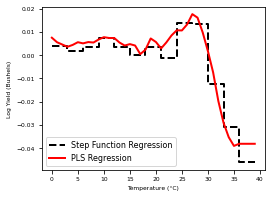

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


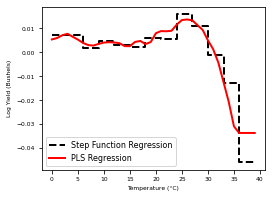

In [3]:
# Figure 4: Nonlinear temperature effects.
# Read the corn data
df_corn = pd.read_csv("/Users/ababii/Library/CloudStorage/Dropbox/SchlenkerRoberst2009/corn.csv")
df_corn['time40C'] = 0

for i in df_corn['state'].unique() :
    df_corn = df_corn.drop(columns=['state_' + str(i)])

# Obtain the residuals for the PLS regression, adjusted for the impact of control variables
r1_corn, r2_corn = control_regression(df_corn, 'all', 'time')
n = r2_corn.shape[0]
T = r2_corn.shape[1]

ξ = 0.01
τ = 1.01 
δ = 0.1

m_max = 10
s = np.linspace(0, 36, num=T)
ds = s[1] - s[0]

# Compute the optimal mhat, early stopped PLS, step function model and produce plots for corn yield
mhat_corn = early_stopping(r1_corn, r2_corn, n, s, ξ, τ, δ, m_max)
beta_pls_corn = yield_temperature(r1_corn, r2_corn, T=T, m_max=m_max, n=n, ds=ds)
step_dummy_beta_corn = step_model_3C(df_corn, 'all')
step_pls_graph(beta_pls_corn, step_dummy_beta_corn, 'corn', m=mhat_corn, save=True)

# Read the soybean data
df_soybeans = pd.read_csv("/Users/ababii/Library/CloudStorage/Dropbox/SchlenkerRoberst2009/soybeans.csv")
df_soybeans['time40C'] = 0

for i in df_soybeans['state'].unique() :
    df_soybeans = df_soybeans.drop(columns=['state_' + str(i)])

r1_soybeans, r2_soybeans = control_regression(df_soybeans, 'all', 'time')

n = r2_soybeans.shape[0]
T = r2_soybeans.shape[1]

# Compute the optimal mhat, early stopped PLS, step function model and produce plots for soybeans yield
mhat_soy = early_stopping(r1_soybeans, r2_soybeans, n, s, ξ, τ, δ, m_max)
beta_pls_soybeans = yield_temperature(r1_soybeans, r2_soybeans, T=T, m_max=m_max, n=n, ds=ds)
step_dummy_beta_soybeans = step_model_3C(df_soybeans, 'all')
step_pls_graph(beta_pls_soybeans, step_dummy_beta_soybeans, 'soybeans', m=mhat_soy, save=True)


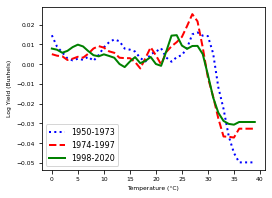

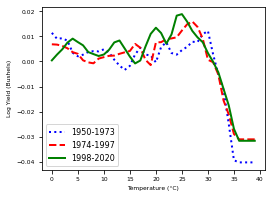

In [4]:
# Figure 5: Adaptation.
# Comparison of the PLS estimator for corn yield over three periods: 1950-1973, 1974-1997, 1998-2020
beta_pls_comparison_corn = []
for year in range(1950, 2020, 24) : 
    start_year = year
    end_year = year + 23
    if end_year > 2020 :
        end_year = 2020
    r1, r2 = control_regression(df_corn, (start_year, end_year), 'time')
    n = r2.shape[0]
    T = r2.shape[1]
    
    beta_pls_comparison_corn.append(yield_temperature(r1, r2, T=T, m_max=m_max, n=n, ds=ds))
comparison_pls_graph(beta_pls_comparison_corn, 'corn', m=mhat_corn, save=True)

# Comparison of the PLS estimator for soybean yield over three periods: 1950-1973, 1974-1997, 1998-2020
beta_pls_comparison_soybeans = []
for year in range(1950, 2020, 24) : 
    start_year = year
    end_year = year + 23
    if end_year > 2020 :
        end_year = 2020
    r1, r2 = control_regression(df_soybeans, (start_year, end_year), 'time')
    n = r2.shape[0]
    T = r2.shape[1]
    
    beta_pls_comparison_soybeans.append(yield_temperature(r1, r2, T=T, m_max=m_max, n=n, ds=ds))
    
comparison_pls_graph(beta_pls_comparison_soybeans, 'soybeans', m=mhat_soy, save=True)